## Objetivo del taller

-   Consultar, descargar y **cargar en Python** imágenes Sentinel (S2
    óptico y S1 radar).
-   Crear **composites** (RGB), índices (p. ej. **NDVI**), **enmascarar
    nubes**, recortar por AOI y **exportar GeoTIFF**.
-   Dos rutas de trabajo:
    1.  **Flujo A (recomendado):** STAC de Microsoft Planetary Computer
        (S2-L2A y S1-RTC).  
    2.  **Flujo B:** lectura **local** de productos `.SAFE`
        (carpetas/JP2/GeoTIFF) con `rasterio`/`rioxarray`.

------------------------------------------------------------------------


## Requisitos e instalación (Conda)

``` bash
# crear entorno (opcional)
conda create -n sentinel_env python=3.11 -y
conda activate sentinel_env

# paquetes base
pip install rasterio rioxarray xarray geopandas shapely
pip install matplotlib numpy tqdm

# acceso vía STAC (Planetary Computer)
pip install pystac-client odc-stac planetary-computer stackstac

# (opcional) filtros y utilidades
pip install scipy scikit-image
```



> Nota: Para usar Planetary Computer, muchas colecciones requieren
> **firma de URLs** con `planetary_computer`. El registro de cuenta es
> gratuito.

------------------------------------------------------------------------


## Configurar el área de interés (AOI)

Defina su **caja** (lon/lat) o cargue un **GeoJSON**. Ajuste estas
variables:

In [1]:
# Coordenadas aproximadas de Aguascalientes (lon_min, lat_min, lon_max, lat_max)
bbox = [-102.5, 21.6, -101.8, 22.2]

# Intervalo temporal (ISO 8601)
timerange = "2024-11-01/2024-12-15"
max_cloud = 20  # % nubes (para Sentinel-2)


------------------------------------------------------------------------

## Flujo A · Sentinel-2 L2A (Planetary Computer, STAC)

### 1) Buscar escenas con STAC

In [2]:
from pystac_client import Client
import planetary_computer as pc

# Conectar al catálogo STAC de Microsoft Planetary Computer
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Mostrar información sobre el catálogo STAC
print(f"Catálogo STAC: {stac.title}")
print(f"Colecciones disponibles: {len(list(stac.get_collections()))}")

# Buscar escenas Sentinel-2 L2A que cumplan los criterios definidos
search = stac.search(
    collections=["sentinel-2-l2a"],  # Colección de Sentinel-2 Level 2A
    bbox=bbox,                       # Área de interés definida previamente
    datetime=timerange,              # Rango temporal definido previamente
    query={"eo:cloud_cover": {"lt": max_cloud}},  # Filtro de cobertura de nubes
    max_items=5,                     # Limitar a 5 escenas máximo
)

# Obtener la lista de elementos (escenas) encontrados
items = list(search.get_items())

# Mostrar cuántas escenas se encontraron y el ID de la primera escena
print(f"Escenas encontradas: {len(items)}")
if items:
    print(f"Primera escena: {items[0].id}")

Catálogo STAC: Microsoft Planetary Computer STAC API
Colecciones disponibles: 126


/opt/miniconda3/envs/sentinel_env/lib/python3.11/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Escenas encontradas: 5
Primera escena: S2B_MSIL2A_20241214T171629_R112_T14QKK_20241214T210356



------------------------------------------------------------------------

### 2) Cargar bandas con *stackstac* → `xarray`

In [3]:
import stackstac, xarray as xr

# Firmar el item STAC para acceso autorizado a los activos (URLs firmadas)
item = pc.sign(items[0])  

# Seleccionar las bandas de interés: Rojo (B04), Verde (B03), Azul (B02), NIR (B08) y clasificación de escena (SCL)
assets = ["B04", "B03", "B02", "B08", "SCL"]  

# Apilar las bandas seleccionadas en un solo DataArray usando stackstac
da = stackstac.stack(
    item,
    assets=assets,
    chunksize=2048,      # Tamaño de los bloques para procesamiento con Dask (ajustar según RAM disponible)
    epsg=32614,          # Proyección UTM zona 14N (México central)
    dtype="float64",     # Tipo de dato; usar float32 si se requiere menor uso de memoria
    rescale=False,       # Mantener valores originales (no escalar reflectancia)
    fill_value=0.0,      # Valor para píxeles sin datos (nubes, fuera de imagen, etc.)
)

# Convertir el DataArray apilado en un Dataset, separando cada banda como variable independiente
ds = da.to_dataset(dim="band")  # Acceso: ds["B04"], ds["B03"], ds["B02"], ds["B08"], ds["SCL"]

# Mostrar el Dataset resultante
ds

<xarray.Dataset> Size: 5GB
Dimensions:                                  (time: 1, y: 10981, x: 10981,
                                              band: 5)
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 8B 2024-12...
    id                                       (time) <U54 216B 'S2B_MSIL2A_202...
  * x                                        (x) float64 88kB 1.979e+05 ... 3...
  * y                                        (y) float64 88kB 2.502e+06 ... 2...
    s2:generation_time                       <U27 108B '2024-12-14T21:03:56.0...
    s2:medium_proba_clouds_percentage        float64 8B 0.003215
    ...                                       ...
    title                                    (band) <U29 580B 'Band 4 - Red -...
    gsd                                      (band) float64 40B 10.0 ... 20.0
    common_name                              (band) object 40B 'red' ... None
    center_wavelength                        (band) object 40B 0.665 ... None
    full_width_half_max                      (band) object 40B 0.038 ... None
    epsg                                     int64 8B 32614
Dimensions without coordinates: band
Data variables:
    B04                                      (time, y, x) float64 965MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03                                      (time, y, x) float64 965MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02                                      (time, y, x) float64 965MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08                                      (time, y, x) float64 965MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL                                      (time, y, x) float64 965MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32614, bounds=(197871.45501914964, 238854...
    crs:            epsg:32614
    transform:      | 10.31, 0.00, 197871.46|\n| 0.00,-10.31, 2501784.32|\n| ...
    resolution_xy:  (10.312250105229813, 10.312043773016395)


> *Tip:* Los valores de reflectancia de S2-L2A suelen venir escalados
> (0–10000). Para visualizar, divida entre **10000** y recorte a
> \[0,1\].

------------------------------------------------------------------------

### 3) Compuesto RGB verdadero (B4-B3-B2) y falso color NIR (B8-B4-B3)


In [4]:
import numpy as np
import xarray as xr

def stretch01(arr, low=0, high=10000):
    """
    Función para normalizar valores de reflectancia Sentinel-2 L2A al rango [0,1].
    
    Parameters:
    -----------
    arr : xarray.DataArray
        Array con valores de reflectancia (típicamente 0-10000 en S2-L2A)
    low : int, optional
        Valor mínimo para el recorte (default: 0)
    high : int, optional  
        Valor máximo para el recorte (default: 10000)
        
    Returns:
    --------
    xarray.DataArray
        Array normalizado entre 0 y 1 para visualización
    """
    arr = arr.clip(low, high)
    return ((arr - low) / (high - low)).clip(0, 1)

# Crear compuesto RGB verdadero (B04-B03-B02: Rojo-Verde-Azul)
rgb_true = xr.concat([ds["B04"], ds["B03"], ds["B02"]], dim="band").isel(time=0).transpose("band", "y", "x")
rgb_true_viz = stretch01(rgb_true)

# Crear compuesto falso color NIR (B08-B04-B03: NIR-Rojo-Verde)
# Resalta vegetación en tonos rojos debido al NIR
rgb_false = xr.concat([ds["B08"], ds["B04"], ds["B03"]], dim="band").isel(time=0).transpose("band", "y", "x")
rgb_false_viz = stretch01(rgb_false)

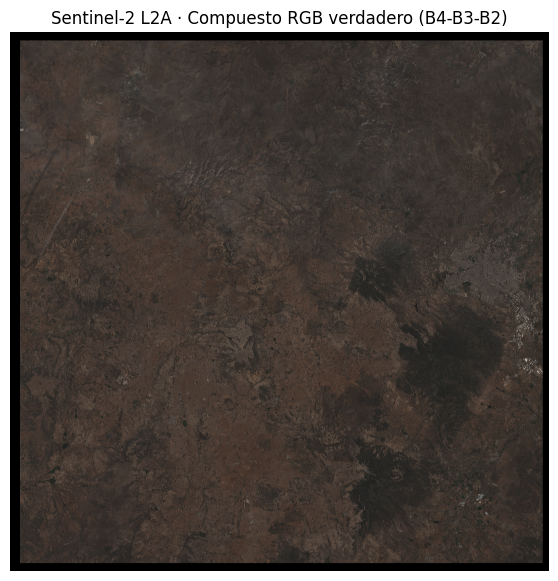

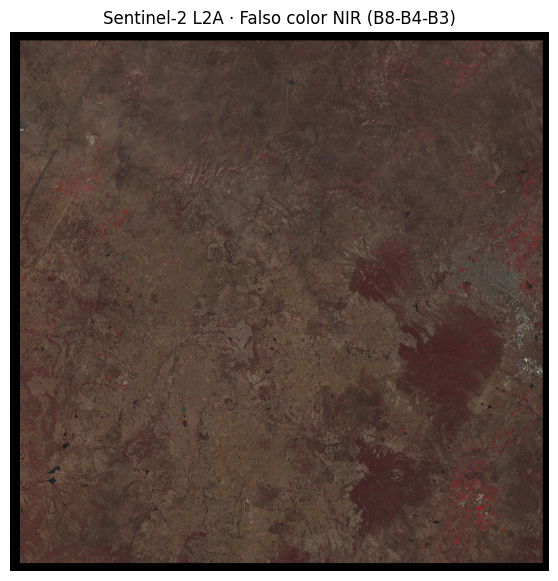

/opt/miniconda3/envs/sentinel_env/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/miniconda3/envs/sentinel_env/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(np.moveaxis(rgb_true_viz.values, 0, -1))
plt.title("Sentinel-2 L2A · Compuesto RGB verdadero (B4-B3-B2)")
plt.axis("off")
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(np.moveaxis(rgb_false_viz.values, 0, -1))
plt.title("Sentinel-2 L2A · Falso color NIR (B8-B4-B3)")
plt.axis("off")
plt.show()


------------------------------------------------------------------------

### 4) NDVI y **máscara de nubes** (SCL o QA60)
-   Máscara SCL (Scene Classification Layer, banda 11):  
    -   0: No data  
    -   1: Saturated or defective  
    -   2: Dark area pixels  
    -   3: Cloud shadows  
    -   4: Vegetation  
    -   5: Bare soils  
    -   6: Water  
    -   7: Clouds low probability / Unclassified  
    -   8: Clouds medium probability  
    -   9: Clouds high probability  
    -   10: Thin cirrus  
    -   11: Snow or ice
-   Máscara QA60 (banda 10):  
    -   Bit 10: opaque clouds  
    -   Bit 11: cirrus clouds

In [6]:
# Cálculo del Índice de Vegetación de Diferencia Normalizada (NDVI)
# NDVI = (NIR - Rojo) / (NIR + Rojo)

# Extraer bandas NIR (B08) y Roja (B04) y convertir a float32 para eficiencia de memoria
nir = ds["B08"].astype("float32")
red = ds["B04"].astype("float32")

# Calcular NDVI usando la fórmula estándar
ndvi = (nir - red) / (nir + red)

# Recortar valores NDVI al rango válido [-1, 1]
ndvi = ndvi.clip(-1, 1)
ndvi.name = "NDVI"

# Crear máscara de nubes usando la banda SCL (Scene Classification Layer)
# SCL: Scene Classification Layer (L2A). Identificamos píxeles de nubes y sombras
# 3 = Sombra de nubes, 8 = Nubes probabilidad media, 9 = Nubes probabilidad alta, 
# 10 = Cirros delgados, 11 = Nieve
scl = ds["SCL"]
cloud_mask = scl.isin([3, 8, 9, 10])

# Aplicar máscara de nubes al NDVI: reemplazar píxeles de nubes con NaN
ndvi_clear = ndvi.where(~cloud_mask)

# Mostrar los resultados
ndvi, ndvi_clear

(<xarray.DataArray 'NDVI' (time: 1, y: 10981, x: 10981)> Size: 482MB
 dask.array<clip, shape=(1, 10981, 10981), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
 Coordinates: (12/37)
   * time                                     (time) datetime64[ns] 8B 2024-12...
     id                                       (time) <U54 216B 'S2B_MSIL2A_202...
   * x                                        (x) float64 88kB 1.979e+05 ... 3...
   * y                                        (y) float64 88kB 2.502e+06 ... 2...
     s2:generation_time                       <U27 108B '2024-12-14T21:03:56.0...
     s2:medium_proba_clouds_percentage        float64 8B 0.003215
     ...                                       ...
     s2:thin_cirrus_percentage                float64 8B 0.0
     s2:snow_ice_percentage                   float64 8B 0.0
     s2:granule_id                            <U62 248B 'S2B_OPER_MSI_L2A_TL_2...
     s2:product_uri                           <U65 260B 'S2B_MSIL2A_

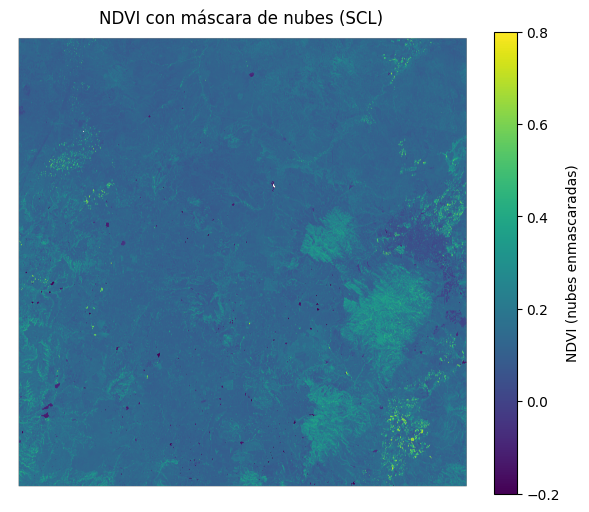

In [7]:
plt.figure(figsize=(7,6))
im = plt.imshow(ndvi_clear.squeeze(), vmin=-0.2, vmax=0.8)
plt.colorbar(im, fraction=0.046, pad=0.04, label="NDVI (nubes enmascaradas)")
plt.title("NDVI con máscara de nubes (SCL)")
plt.axis("off")
plt.show()


------------------------------------------------------------------------

### 5) Recorte por AOI (GeoJSON/Shapefile) y exportar GeoTIFF


In [8]:
import geopandas as gpd
import rioxarray

# === DEFINICIÓN DEL ÁREA DE INTERÉS (AOI) ===
# Opción 1: Cargar AOI desde archivo GeoJSON/Shapefile
# aoi = gpd.read_file("aoi.geojson")

# Opción 2: Crear AOI rectangular desde la bbox definida anteriormente
from shapely.geometry import box
aoi = gpd.GeoDataFrame(geometry=[box(*bbox)], crs="EPSG:4326")

# === PREPARACIÓN DE DATOS PARA RECORTE ===
# Asignar sistema de coordenadas al NDVI (UTM Zona 14N)
ndvi_clear.rio.write_crs("EPSG:32614", inplace=True)

# Reproyectar AOI al mismo sistema de coordenadas que el NDVI
aoi_proj = aoi.to_crs(ndvi_clear.rio.crs)

# === RECORTE ESPACIAL ===
# Recortar el NDVI usando la geometría del AOI proyectada
# drop=True elimina píxeles completamente fuera del AOI
ndvi_clip = ndvi_clear.rio.clip(aoi_proj.geometry, aoi_proj.crs, drop=True)

# === EXPORTACIÓN A GEOTIFF ===
# Guardar el NDVI recortado como archivo GeoTIFF con compresión
ndvi_clip.rio.to_raster("ndvi_clip.tif", compress="deflate")

print("Archivo exportado: ndvi_clip.tif")

Archivo exportado: ndvi_clip.tif



------------------------------------------------------------------------

## Flujo A · Sentinel-1 RTC (Radar, VV/VH)

El conjunto **sentinel-1-rtc** en Planetary Computer ya viene
**radiométrica y geométricamente corregido (RTC)**. Así evitamos pasos
complejos (calibración/terreno) típicos de S1-GRD crudo.


In [9]:
# === BÚSQUEDA Y CARGA DE DATOS SENTINEL-1 RTC ===

# Buscar escenas Sentinel-1 RTC (Radiometric Terrain Corrected) en el catálogo STAC
search_s1 = stac.search(
    collections=["sentinel-1-rtc"],  # Colección Sentinel-1 ya corregida radiométrica y geométricamente
    bbox=bbox,                       # Área de interés definida previamente
    datetime=timerange,              # Rango temporal definido previamente
    query={"sar:polarizations": {"in": [["VV", "VH"], ["VV"], ["VH"]]}},  # Polarizaciones disponibles
    max_items=5,                     # Limitar a 5 escenas máximo
)

# Obtener lista de escenas encontradas
items_s1 = list(search_s1.get_items())
print(f"Escenas encontradas: {len(items_s1)}")

# Firmar la primera escena para acceso autorizado a los activos
item_s1 = pc.sign(items_s1[0])
print(item_s1.assets.keys())  # Mostrar activos disponibles (bandas/polarizaciones)

# Apilar las polarizaciones VV y VH en un DataArray usando stackstac
da_s1 = stackstac.stack(
    item_s1,
    assets=["vv", "vh"],     # Polarizaciones: VV (vertical-vertical), VH (vertical-horizontal)
    chunksize=2048,          # Tamaño de bloques para procesamiento con Dask
    dtype="float64",         # Tipo de dato para valores de backscatter
    rescale=False,           # Mantener valores originales de backscatter (sigma0)
    fill_value=0.0,          # Valor para píxeles sin datos
    epsg=32614               # Proyección UTM zona 14N (México central)
)

# Convertir DataArray a Dataset para acceso independiente a cada polarización
ds_s1 = da_s1.to_dataset("band")  # Acceso: ds_s1["vv"], ds_s1["vh"]
ds_s1

/opt/miniconda3/envs/sentinel_env/lib/python3.11/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Escenas encontradas: 5
dict_keys(['vh', 'vv', 'tilejson', 'rendered_preview'])


<xarray.Dataset> Size: 10GB
Dimensions:                                (time: 1, y: 21746, x: 28327, band: 2)
Coordinates: (12/44)
  * time                                   (time) datetime64[ns] 8B 2024-12-1...
    id                                     (time) <U66 264B 'S1A_IW_GRDH_1SDV...
  * x                                      (x) float64 227kB -2.257e+04 ... 2...
  * y                                      (y) float64 174kB 2.586e+06 ... 2....
    sar:looks_range                        int64 8B 5
    sat:absolute_orbit                     int64 8B 56923
    ...                                     ...
    file:checksum                          (band) <U32 256B '8afd0d749e625388...
    title                                  (band) <U41 328B 'VV: vertical tra...
    raster:bands                           object 8B {'nodata': -32768, 'data...
    file:size                              (band) int64 16B 1840908632 184199...
    description                            (band) <U173 1kB 'Terrain-correcte...
    epsg                                   int64 8B 32614
Dimensions without coordinates: band
Data variables:
    vv                                     (time, y, x) float64 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh                                     (time, y, x) float64 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32614, bounds=(-22569.92922947568, 236613...
    crs:            epsg:32614
    transform:      | 9.99, 0.00,-22569.93|\n| 0.00,-10.12, 2586242.67|\n| 0....
    resolution_xy:  (9.991115196757717, 10.121844730027098)

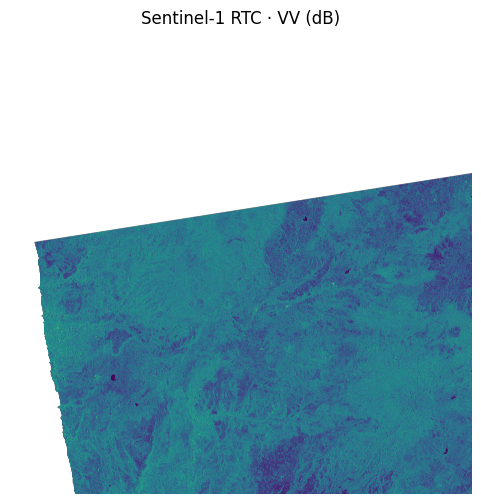

In [10]:
# === Procesamiento y visualización de Sentinel-1 RTC (VV) ===

# Extraer la polarización VV del dataset
vv = ds_s1["vv"]

# Convertir valores de retrodispersión (backscatter) a decibelios (dB) para visualización
# La transformación logarítmica es estándar en radar: dB = 10 * log10(sigma0)
vv_db = 10 * np.log10(vv.where(vv > 0))  # Evita logaritmo de valores <= 0

# Recortar el área para visualización rápida (primeros 10,000 píxeles en x/y)
vv_db_small = vv_db.squeeze().isel(y=slice(0,10000), x=slice(0,10000))

plt.figure(figsize=(7,6))
# plt.imshow(vv_db.squeeze(), vmin=-20, vmax=5)  
plt.imshow(vv_db_small, vmin=-20, vmax=5)
plt.title("Sentinel-1 RTC · VV (dB)")
plt.axis("off")
plt.show()


> *Opcional:* filtro de moteado (**speckle**) con mediana (ventana 3–5
> px) usando `scipy.ndimage.median_filter`.

------------------------------------------------------------------------





## Descarga masiva (opcional) con `pystac-client` + `requests`


In [11]:
# Guardar activos (bandas) a disco desde un item firmado
import requests, os

def download_assets(item, assets=("B04","B03","B02","B08","SCL"), outdir="S2_download"):
    os.makedirs(outdir, exist_ok=True)
    signed = pc.sign(item)
    for a in assets:
        href = signed.assets[a].href
        fname = os.path.join(outdir, f"{signed.id}_{a}.tif")
        with requests.get(href, stream=True) as r:
            r.raise_for_status()
            with open(fname, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk: f.write(chunk)
    return outdir

out = download_assets(items[0])
out

'S2_download'


------------------------------------------------------------------------

## Consejos prácticos

-   Trabaje con **L2A** (reflectancia de superficie) cuando sea posible.
-   Para radar, use **S1-RTC** (corrigido) si no domina preprocesos GRD.
-   Controle memoria con **chunks** (Dask) y recortes por AOI.
-   Documente todo en **Quarto/Jupyter**, con nombres de archivo
    reproducibles.
-   Revise metadatos (CRS, resolución) antes de exportar o combinar
    capas.

------------------------------------------------------------------------

## Referencias rápidas

-   Catálogo STAC de **Planetary Computer**:
    `https://planetarycomputer.microsoft.com/catalog`
-   Colecciones: `sentinel-2-l2a`, `sentinel-1-rtc`
-   Paquetes: `pystac-client`, `planetary-computer`, `stackstac`,
    `odc-stac`, `rioxarray`, `rasterio`

**¡Listo!** Esta presentación incluye ambos flujos para que puedas
adaptar el proceso a tu infraestructura (online/offline).